In [1]:
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

In [6]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [7]:
from tqdm import tqdm
from tabulate import tabulate

In [8]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [9]:
data = Dataset("C:\\Users\\Hammad\\Desktop\\Zeshan New Work\\Dataset\\SYMPTOM_Resized", test_size=0.3, img_size=224)
print(data.X.shape, data.y.shape)

(998, 224, 224, 3) (998, 17)


In [10]:
# Model based on base paper
def make_model(
    nclasses: int, *, dropout_rate: float
) -> tf.keras.Model:
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    #model.add(Conv2D(24, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(48, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(nclasses, activation="softmax"))
    return model

In [11]:
def evaluate_model(
    nclasses, X, y, X_test, y_test, *,
    epochs: int, batch_size: int, learning_rate: float,
    model_maker = make_model, **model_params
) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    model = model_maker(nclasses, **model_params)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return model, train_acc, test_acc

In [12]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, test_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, test_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_test_fold = tf.gather(X, test_index)
        y_test_fold = tf.gather(y, test_index)
        
        # Train and evaluate the model.
        _, train_acc, test_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_test_fold,
            y_test_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "test_mean": np.mean(test_accs),
        "test_std": np.std(test_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Test", results["test_mean"], results["test_std"]]
                ],
                headers=["Set", "Accuracy", "Standard Deviation"]
            )
        )
    
    return results

In [13]:
# We'll refer to these values throughout the notebook.
# Parameters based on base paper
default_cv_evaluate_params = {
    "X": data.X,
    "y": data.y,
    "labels": data.labels,
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 100,
    "batch_size": 64,
    "verbose": False,
    "learning_rate": 0.0001,
    "dropout_rate": 0.3,
}

In [14]:
_ = cv_evaluate_model(
    **{
        **default_cv_evaluate_params,
        "verbose": True
    }
)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/100
15/15 [==============================] - 65s 4s/step - loss: 3.6700 - accuracy: 0.1614 - val_loss: 4.9602 - val_accuracy: 0.1800
Epoch 2/100
15/15 [==============================] - 56s 4s/step - loss: 1.7691 - accuracy: 0.4828 - val_loss: 3.3071 - val_accuracy: 0.2800
Epoch 3/100
 6/15 [===========>..................] - ETA: 36s - loss: 1.1804 - accuracy: 0.6431

  0%|                                                                                           | 0/30 [02:30<?, ?it/s]


KeyboardInterrupt: 

In [30]:
X = data.X
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []
    
# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), input_shape=(224,224,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    #model.add(Conv2D(24, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(48, (3,3), activation="relu"))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D())
    #model.add(Conv2D(64, (3,3), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(17, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 64) #batch - 64
    third_of_total_steps = math.floor(100 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/100
15/15 [==============================] - 56s 4s/step - loss: 4.1622 - accuracy: 0.2259 - val_loss: 4.7746 - val_accuracy: 0.1600
Epoch 2/100
15/15 [==============================] - 57s 4s/step - loss: 1.8252 - accuracy: 0.5474 - val_loss: 2.9957 - val_accuracy: 0.2300
Epoch 3/100
15/15 [==============================] - 61s 4s/step - loss: 1.0677 - accuracy: 0.7149 - val_loss: 3.7113 - val_accuracy: 0.0600
Epoch 4/100
15/15 [==============================] - 54s 4s/step - loss: 0.6797 - accuracy: 0.8045 - val_loss: 3.3920 - val_accuracy: 0.1800
Epoch 5/100
15/15 [==============================] - 53s 3s/step - loss: 0.6245 - accuracy: 0.8235 - val_loss: 2.5857 - val_accuracy: 0.2900
Epoch 6/100
15/15 [==============================] - 52s 3s/step - loss: 0.4843 - accuracy: 0.8711 - val_loss: 2.1301 - val_accuracy: 0.3800
Epoch 7/100
15/15 [==============================] - 52s 3s/step - loss: 0.5332 - accuracy: 0.8584 - val_loss: 2.2287 - val_accuracy: 0.4400
Epoch 8/100
1

Epoch 59/100
15/15 [==============================] - 62s 4s/step - loss: 0.0679 - accuracy: 0.9764 - val_loss: 2.9944 - val_accuracy: 0.5800
Epoch 60/100
15/15 [==============================] - 53s 4s/step - loss: 0.1075 - accuracy: 0.9774 - val_loss: 3.1209 - val_accuracy: 0.5900
Epoch 61/100
15/15 [==============================] - 53s 4s/step - loss: 0.0965 - accuracy: 0.9756 - val_loss: 3.1020 - val_accuracy: 0.5900
Epoch 62/100
15/15 [==============================] - 56s 4s/step - loss: 0.0582 - accuracy: 0.9843 - val_loss: 3.0788 - val_accuracy: 0.5900
Epoch 63/100
15/15 [==============================] - 70s 4s/step - loss: 0.1458 - accuracy: 0.9725 - val_loss: 3.0374 - val_accuracy: 0.5900
Epoch 64/100
15/15 [==============================] - 64s 4s/step - loss: 0.0734 - accuracy: 0.9807 - val_loss: 3.0319 - val_accuracy: 0.5900
Epoch 65/100
15/15 [==============================] - 59s 4s/step - loss: 0.0647 - accuracy: 0.9740 - val_loss: 3.0163 - val_accuracy: 0.5900
Epoch 

  3%|██▌                                                                         | 1/30 [1:31:52<44:24:24, 5512.56s/it]

Epoch 1/100
15/15 [==============================] - 61s 4s/step - loss: 4.5711 - accuracy: 0.1666 - val_loss: 9.9348 - val_accuracy: 0.1200
Epoch 2/100
15/15 [==============================] - 58s 4s/step - loss: 1.9859 - accuracy: 0.4785 - val_loss: 3.4864 - val_accuracy: 0.1900
Epoch 3/100
15/15 [==============================] - 58s 4s/step - loss: 1.2029 - accuracy: 0.6462 - val_loss: 2.9155 - val_accuracy: 0.1800
Epoch 4/100
15/15 [==============================] - 59s 4s/step - loss: 0.9198 - accuracy: 0.7490 - val_loss: 3.9599 - val_accuracy: 0.1000
Epoch 5/100
 3/15 [=====>........................] - ETA: 49s - loss: 0.6693 - accuracy: 0.8325

  3%|██▌                                                                         | 1/30 [1:36:06<46:27:06, 5766.44s/it]


KeyboardInterrupt: 

In [31]:
print ("Train Acc", train_accs)
print ("Test Auc", test_accs)

Train Acc [1.0]
Test Auc [0.6000000238418579]


In [32]:
# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

print(
    tabulate(
        [
            ["Train", results["Train_Acc"], results["Train_std"]],
            ["Test", results["Test_Acc"], results["Test_std"]]
        ],
        headers=["Set", "Accuracy", "Standard Deviation"]
    )
)

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train         1                       0
Test          0.6                     0


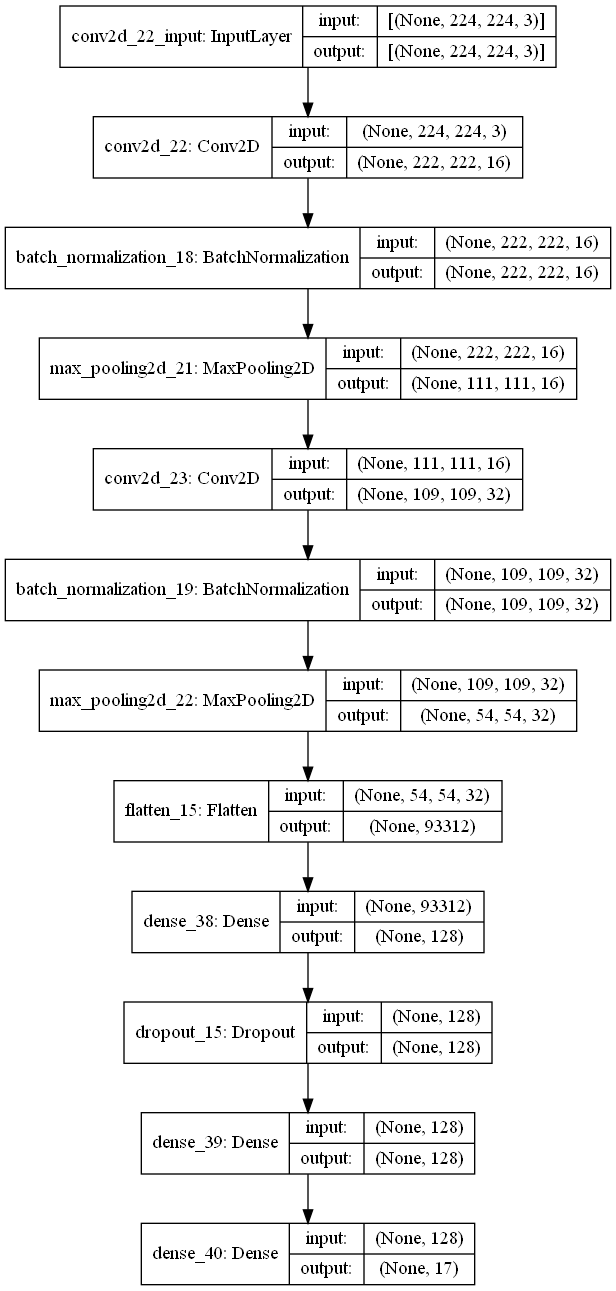

In [33]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB")

In [34]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization_18 (Batc (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_19 (Batc (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 93312)           

In [35]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

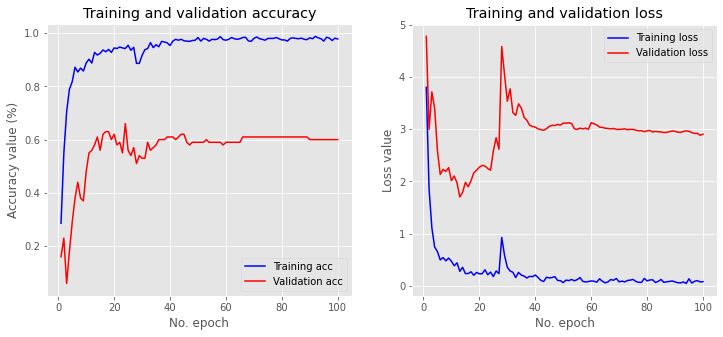

In [36]:
plot_history(history)

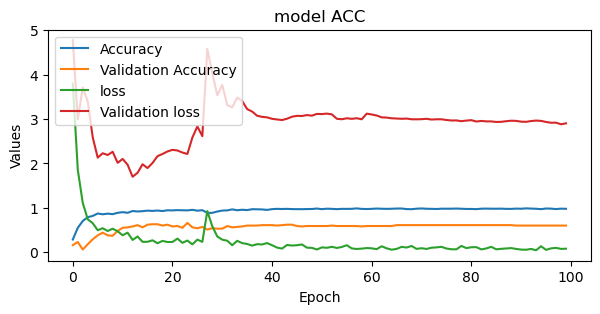

In [37]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("model ACC")
plt.ylabel("Values")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation loss"])
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)

accuracy_score(y_test1, y_pred)

0.1

In [40]:
print('\nAccuracy Score  on test data: ' + str(accuracy_score(y_test1, y_pred)))


Accuracy Score  on test data: 0.1


In [53]:
print(confusion_matrix(y_test1,y_pred))

[[ 5  0  1  0  0  0  0  1  0  0  0  0  1  0  0  2  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  1  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  1  0]
 [ 0  0  0  1  2  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  2  1  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  1  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1]]


In [54]:
print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       1.00      1.00      1.00         3
           2       0.50      1.00      0.67         1
           3       0.71      0.62      0.67         8
           4       0.60      0.75      0.67         4
           5       0.00      0.00      0.00         2
           6       0.83      0.71      0.77         7
           7       0.62      1.00      0.77         5
           8       0.83      1.00      0.91         5
           9       0.50      0.75      0.60         4
          10       0.00      0.00      0.00         1
          11       0.76      0.95      0.84        20
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.73      0.85      0.79        13
          16       1.00      0.50      0.67         2

    accuracy              

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
data.X.shape

(998, 224, 224, 3)

In [11]:
from keras.layers import MaxPool2D
from tensorflow.keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Reshape

X = data.X
y = data.y
labels = data.labels
train_accs, test_accs = [], []
history = []
    
# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(
        n_splits=10, n_repeats=3, random_state=0
    ).split(X, labels),
    total=10*3, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X, train_index) 
    y_train = tf.gather(y, train_index)
    X_test = tf.gather(X, test_index)
    y_test = tf.gather(y, test_index)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    out_shape = model.output_shape
    print('====Model CNN: Output Shape: ', out_shape)
    model.add(Reshape((out_shape[1], out_shape[2] * out_shape[3])))
    inp_shape = model.output_shape
    print('====Model LSTM: Input Shape: ', inp_shape)
    model.add(LSTM(64, activation='relu', return_sequences=True))
    
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(17, activation="softmax"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / 64) #batch - 64
    third_of_total_steps = math.floor(100 * steps_per_epoch / 3) #epoch - 100
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                0.0003,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size=64, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

====Model CNN: Output Shape:  (None, 112, 112, 64)
====Model LSTM: Input Shape:  (None, 112, 7168)
Epoch 1/100
12/15 [=======================>......] - ETA: 56s - loss: 8929.7765 - accuracy: 0.0840 

  0%|                                                                                           | 0/30 [04:10<?, ?it/s]


KeyboardInterrupt: 

In [57]:
# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

print(
    tabulate(
        [
            ["Train", results["Train_Acc"], results["Train_std"]],
            ["Test", results["Test_Acc"], results["Test_std"]]
        ],
        headers=["Set", "Accuracy", "Standard Deviation"]
    )
)

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.966592                     0
Test     0.56                         0


In [69]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
out_shape = model.output_shape
print('====Model CNN: Output Shape: ', out_shape)
model.add(Reshape((out_shape[1], out_shape[2] * out_shape[3])))
inp_shape = model.output_shape
print('====Model LSTM: Input Shape: ', inp_shape)
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(17, activation="softmax"))
print(model.summary())

====Model CNN: Output Shape:  (None, 112, 112, 32)
====Model LSTM: Input Shape:  (None, 112, 3584)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 112, 3584)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 112, 64)           934144    
_________________________________________________________________
flatten_2 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               917632    
____________________

In [65]:
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.convolutional import MaxPooling3D
in_shape = (224, 224, 224, 3) #convLSTM2D is for expected ndim=5, found ndim=4. Full shape received: (None, 224, 224, 3)
model = Sequential()
model.add(ConvLSTM2D(32, kernel_size=(3, 3), padding='same', return_sequences=True, input_shape=in_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2, 2)))
model.add(ConvLSTM2D(64, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(MaxPooling3D(pool_size=(1,2, 2)))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(Activation('relu'))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(Activation('relu'))
model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
model.add(MaxPooling3D(pool_size=(1,2, 2)))
model.add(Dense(320))
model.add(Activation('relu'))
model.add(Dropout(0.5))

out_shape = model.output_shape
print('====Model CNN: Output Shape: ', out_shape)
model.add(Reshape((224, out_shape[2] * out_shape[3] * out_shape[4])))
inp_shape = model.output_shape
print('====Model LSTM: Input Shape: ', inp_shape)
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# model structure summary
print(model.summary())

====Model CNN: Output Shape:  (None, 224, 24, 24, 320)
====Model LSTM: Input Shape:  (None, 224, 184320)
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_38 (ConvLSTM2D) (None, 224, 224, 224, 32) 40448     
_________________________________________________________________
activation_29 (Activation)   (None, 224, 224, 224, 32) 0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 224, 112, 112, 32) 0         
_________________________________________________________________
conv_lst_m2d_39 (ConvLSTM2D) (None, 224, 110, 110, 64) 221440    
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 224, 55, 55, 64)   0         
_________________________________________________________________
conv_lst_m2d_40 (ConvLSTM2D) (None, 224, 53, 53, 96)   553344    
______________